# Generalized Additive Models - GAMs

## Definition and intuition

GAMs provides a useful extensions of linear models, making them more flexible while still retaining much of their interpretability.

GAMs operate under the hypothesis that relationships between the individual predictors and the dependent variable follow smooth patterns that can be linear or nonlinear. 
We can estimate these smooth relationships simultaneously and then predict the target using a link function.  
We can write the GAM structure as:  

$$g(E(Y))=\alpha+f_1(x_1)+⋯+f_p(x_n)$$

Where $g$ is the link function (identity, log, logit...), $n$ is the number of features and $(f_1,f_2,...,f_n)$ are functions we can estimate through non-parametric methods. These function depend on one feature only $(x_1,x_2,...,x_n)$ respectively. $\alpha$ is the bias term.
In other words, the purpose of generalized additive models is to maximize the quality of prediction of a dependent variable $Y$ from various distributions, by estimating unspecific (non-parametric) functions of the predictor variables which are "connected" to the dependent variable via a link function.


<b>GA²Ms - Generalized additive models with pairwise interactions</b>

GA²Ms have a similar structure with added functions that capture interactions between variables.
$$ g(E(Y))=\alpha+\sum_{i\in[1,n]}f_i(x_i)+ \sum_{(i<j)\in[1,n]}f_{ij}(x_i,x_j)$$

Generalized Additive Models was developed and popularized by Hastie and Tibshirani (1990). 

## GAMs and Interpretability 

When a model is additive, the interpretation of the marginal impact of a single variable (the partial derivative) does not depend on the values of the other variables in the model. Hence, by simply looking at the output of the model, we can make simple statements about the effects of the predictive variables that make sense to a nontechnical person.  
So to understand the model we can look at the graph to each function to get the gist of what's happening. For more accuracy we can look at the pairwise interactions as well. However, we are limited to  3 dimensions as we cannot see and interpret on high dimensions.

The model can be seen as :
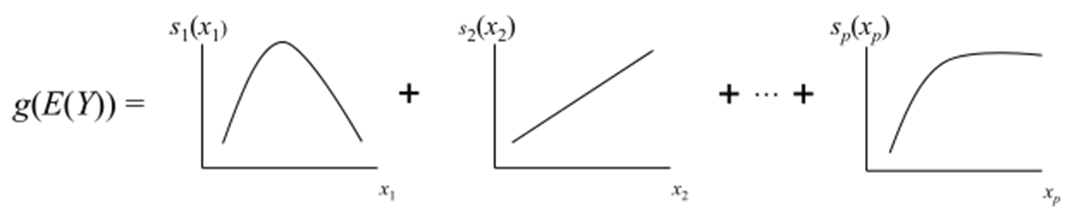


### Characteristics of  this interpretability method
* **Model-specific**: We are restricted to the use of GAMs in order to use this method
* **Global**: We can easily look at the impact of each variable via partial dependencies plot 
* **Local**: This model is additive so we can look at the contribution of each feature given by its own function to the final result

## Importations
For this notebook we will use pyGam: a python library that implements GAMs available on <a href="https://github.com/dswah/pyGAM"> GitHub </a> 

In [1]:
import numpy as np

# import datasets
from mlinutils.datasets import Bikes, Loans

# Libraries specific to GAMs
from pygam import LinearGAM, LogisticGAM
from sklearn.preprocessing import MinMaxScaler


import mlinutils.gam_plots as gamp
import mlinutils.sanity as san

In [2]:
#  make plot outputs appear and be stored within the notebook
%matplotlib inline

### Guidance on how to read this notebook

To see GAMs in action we will interpret their behaviour on two tasks:
* <a href=#reg>Regression with bike sharing</a>
    * <a href=#regm>Model creation and sanity checks</a>
    * <a href=#regg>Global explanation</a>
    * <a href=#regl>Local explanation</a>
* <a href=#clf>Classification with Lending Club</a>
    * <a href=#clfm> Model creation and sanity checks</a>
    * <a href=#clfg> Global explanation</a>
    * <a href=#clfl> Local explanation</a>
* <a href=#cls> Conclusion </a>

## The datasets we're using 

### Data description
The full description of the Datasets that are used in this entire collection of notebooks is available separately 
* Bike sharing: Daily counts of bike rentals from bike sharing along with weather and seasonal information. <a href="bike_sharing_dataset.ipynb">See bike sharing dataset exploration</a>
* Lending club: information on users and wether or not they default on their payments from a peer to peer lending online service <a href="lending_club_dataset.ipynb">see lending club dataset exploration</a>  

### Data importation 

In [3]:
bikes = Bikes()
bk_X_train, bk_X_test, bk_y_train, bk_y_test = bikes.load()

### Data preview
Take a peak into the data we'll be using !

In [4]:
bikes.preview()

This dataset contains 17379 instances with 14 attributes


,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
947,spring,0.0,February,9pm-5am,0.0,Saturday,0.0,Good,5.74,10.605,80.0,0.0000,15.0,42.0
2165,summer,0.0,April,9pm-5am,0.0,Tuesday,1.0,Medium,22.14,25.760,73.0,22.0028,5.0,94.0
11035,summer,1.0,April,9pm-5am,0.0,Monday,1.0,Good,18.04,21.970,44.0,19.9995,67.0,464.0
7080,winter,0.0,October,11am-4pm,0.0,Thursday,1.0,Medium,21.32,25.000,83.0,7.0015,107.0,299.0
7954,winter,0.0,December,9pm-5am,0.0,Saturday,0.0,Good,10.66,12.880,65.0,11.0014,50.0,336.0


### Regression with bike sharing <a name=reg>
* For this regression problem we will use the identity as a liaison function (named g in the definition above) so this boils down to a simple additive model

#### Model creation and sanity checks <a name=regm>

In [5]:
# Model creation
#list describing the data-type of each feature, help GAM package to use the right num of splines for each variable
dtypes = [["categorical", "numerical"][bk_X_train[fn].dtype == np.float64] for fn in bk_X_train.columns]

# n_splines = adjusting the level of smoothness of the predictors function 
linear_gam = LinearGAM(n_splines=10, dtype=dtypes).fit(bk_X_train, bk_y_train)

Let's check GAMs fitting statistics

In [6]:
linear_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     63.1624
Link Function:                     IdentityLink Log Likelihood:                               -145521.2681
Number of Samples:                        13903 AIC:                                            291170.861
                                                AICc:                                          291171.4653
                                                GCV:                                            14131.0631
                                                Scale:                                          14015.5525
                                                Pseudo R-Squared:                                   0.5798
Feature Function   Data Type      Num

Regression Sanity check

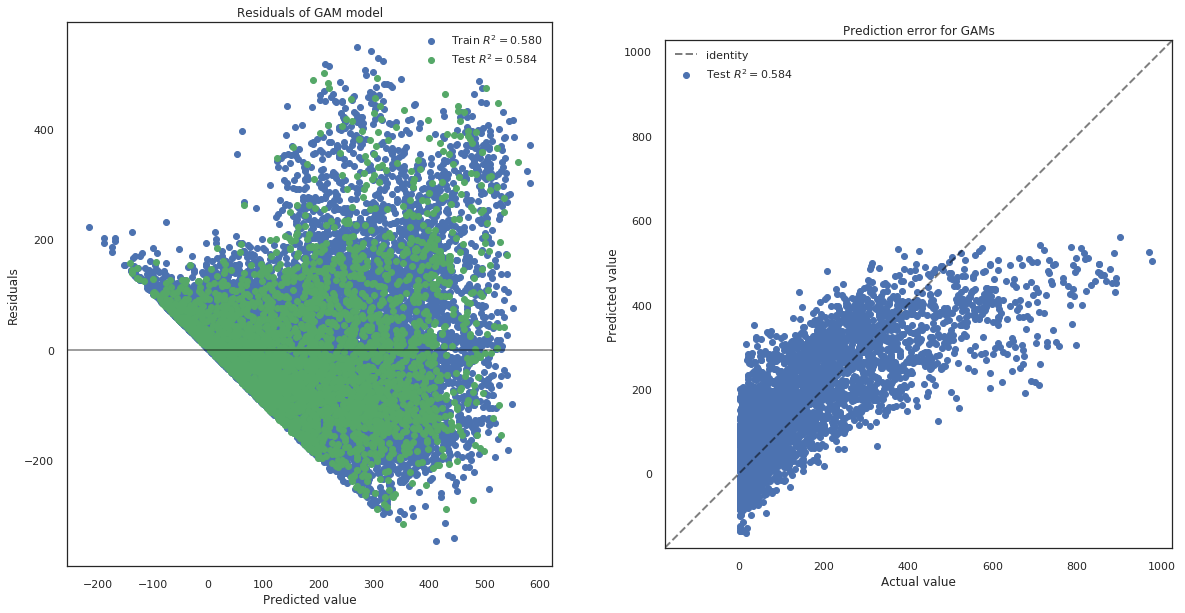

In [7]:
san.gam_regression_sanity_check(linear_gam, bk_X_train, bk_X_test, bk_y_train, bk_y_test)

> Predictive power is fair (R²=0.58) for both train and test set. Model generalizes well to a holdout set of data.

#### Global explanation <a name=regg> 
For the gloabl explanation we will look at the graph that shows  the impact of each feature as presented by the GAM 

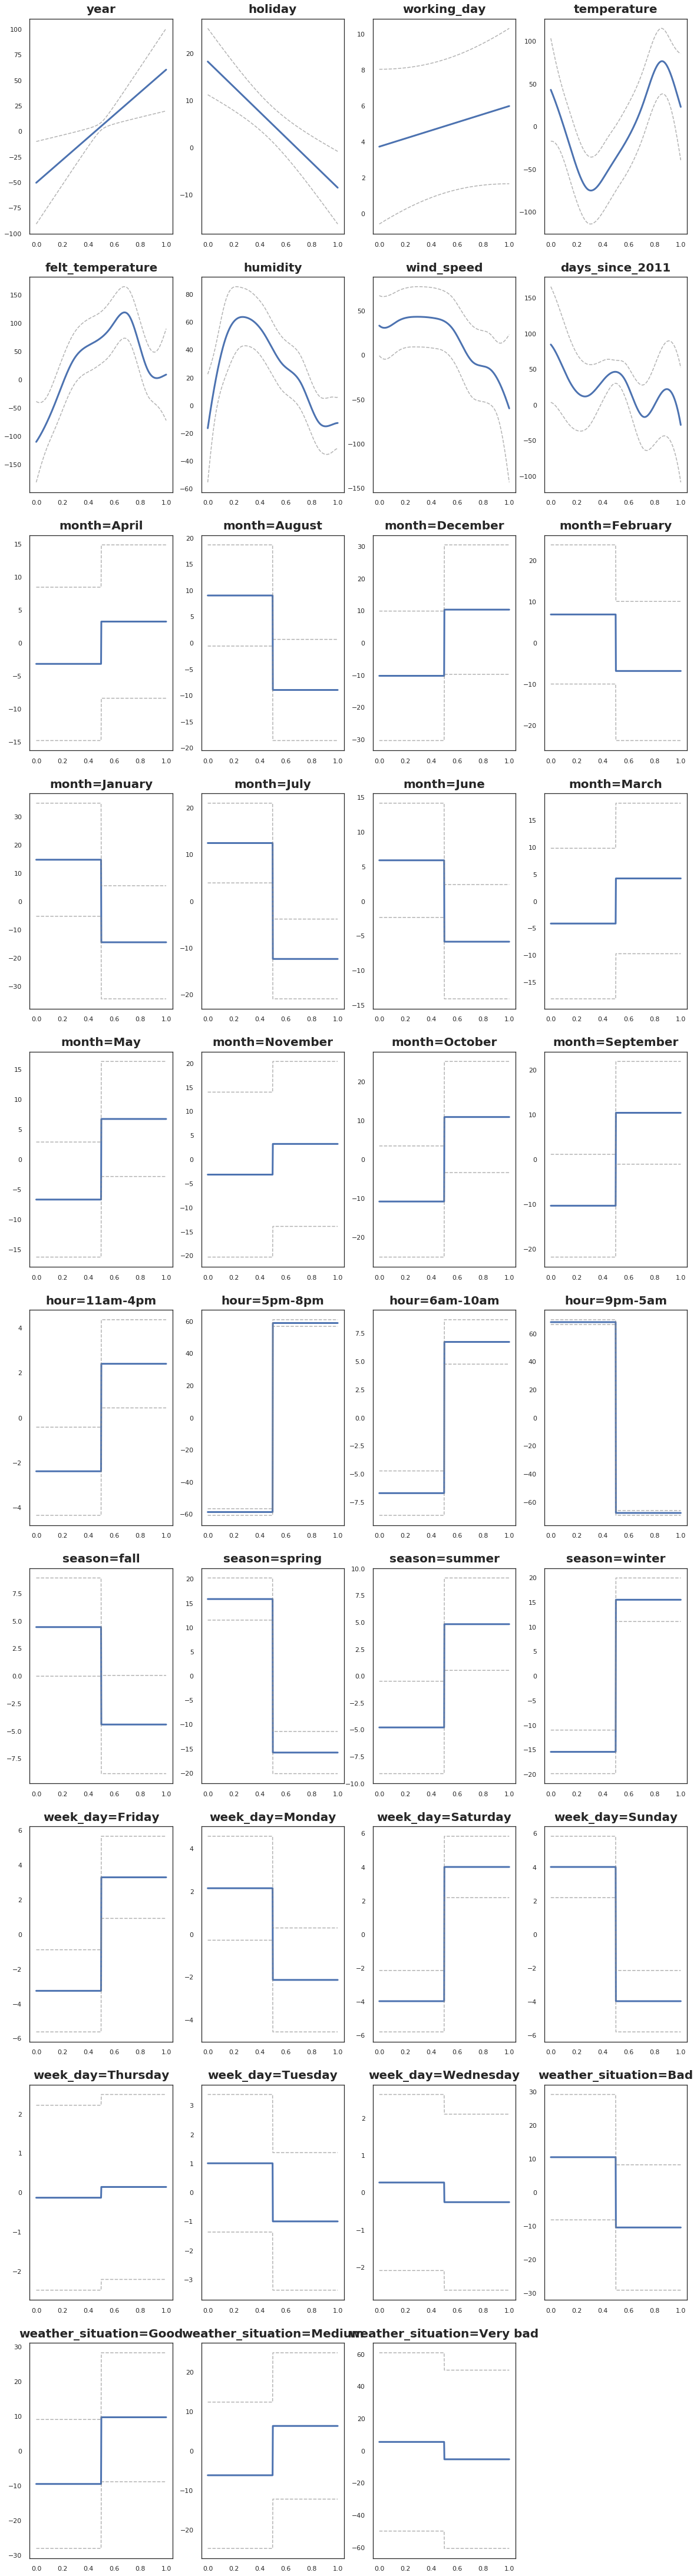

In [8]:
gamp.global_explanation_plot(linear_gam, bk_X_train.columns)

> One of the nice things about GAMs is that their additive nature allows us to explore and interpret individual features by holding others constant. 
> We can already understand a lot about our model and draw some findings:
* Holidays cause a drop in bike rental 
* More rentals on working days
* Felt temperature, wind speed, humidity and weather situation seem to be aligned to the practice of cycling
* Rush hours (6am-10am and 5pm-8pm) increase bike rental while during the night (9pm-am) bike rentals drop.


>However, some variables fitting are not very intuitive:
* `temperature` and `days_since_2011`: we should expect near trends as observed for `felt_temperature` and `year` respectively. Seems GAMs suffers from correlated features.

#### Local explanation <a name=regl>

In [9]:
sample_bike = bk_X_test.iloc[42]

## recovers the original format just for reading convenience
bikes.data.iloc[[sample_bike.name],:]

,season,year,month,hour,holiday,week_day,working_day,weather_situation,temperature,felt_temperature,humidity,wind_speed,count,days_since_2011
4296,fall,0.0,July,9pm-5am,0.0,Saturday,0.0,Good,29.52,33.335,51.0,11.0014,201.0,182.0


The prediction is around 115.38 bikes
Base value (intercept) accounts for 48.39 bikes


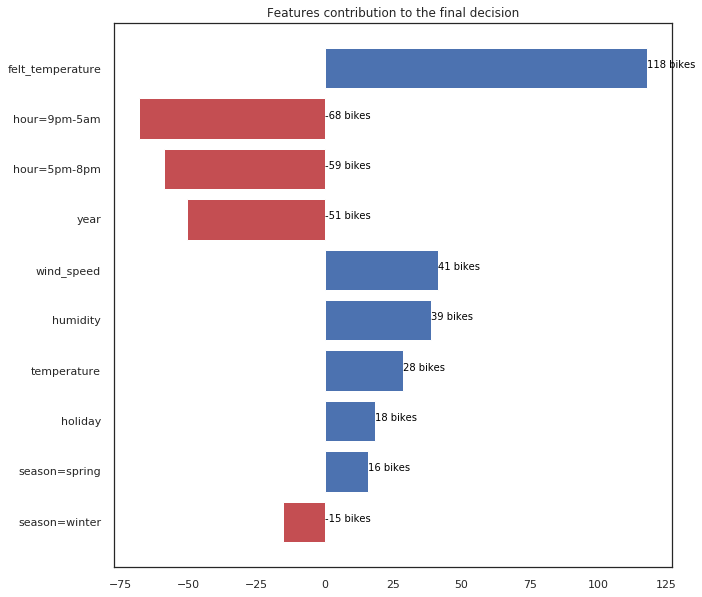

In [10]:
gamp.local_regression_plot(sample_bike, 
                           feature_names=bk_X_test.columns,
                           gam=linear_gam, 
                           target_unity="bikes");

### Classification with Lending Club <a name=clf>
* For this classification problem we will use the logistic function  as a liaison function (named g in the definition above) 

In [11]:
loans = Loans()
ln_X_train, ln_X_test, ln_y_train, ln_y_test = loans.load()

### Data preview
Take a peak into the data we'll be using !

In [12]:
loans.preview()

This dataset contains 98339 instances with 19 attributes


,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
45970,6750.0,9.67,216.76,6.0,3.0,MORTGAGE,80000.0,Source Verified,debt_consolidation,10.58,1.0,0.0,11.0,1833.0,5.3,1.0,1.0,249.007166,0
67558,2700.0,19.05,99.04,4.0,3.0,RENT,38000.0,Not Verified,debt_consolidation,3.57,0.0,0.0,2.0,2695.0,89.8,1.0,1.0,56.017577,0
54900,1600.0,7.90,50.07,7.0,1.0,RENT,42700.0,Source Verified,other,7.50,0.0,0.0,6.0,6693.0,69.0,1.0,1.0,247.003019,0
30639,30000.0,22.95,844.86,2.0,1.0,NONE,105000.0,Verified,debt_consolidation,17.23,0.0,0.0,20.0,12083.0,37.7,1.0,1.0,150.048256,0
65647,9250.0,10.74,301.70,6.0,1.0,OWN,19200.0,Verified,debt_consolidation,12.63,0.0,0.0,5.0,1999.0,58.8,1.0,1.0,88.971026,1


#### Model creation and sanity checks <a name=clfm>

In [13]:
#list describing the data-type of each feature, help GAM package to use the right num of splines for each variable
dtypes = [["categorical", "numerical"][ln_X_train[fn].dtype == np.float64] for fn in ln_X_train.columns]

gam_logistic = LogisticGAM(n_splines=10, penalties="l2").fit(ln_X_train, ln_y_train)

Let's check GAM statistics

In [14]:
gam_logistic.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    100.2524
Link Function:                        LogitLink Log Likelihood:                                -37710.9641
Number of Samples:                        78671 AIC:                                             75622.433
                                                AICc:                                           75622.6965
                                                UBRE:                                               2.9623
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.089
Feature Function   Data Type      Num

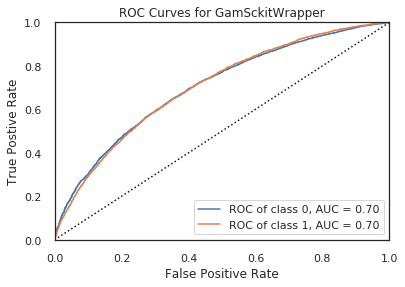

In [15]:
gam_wrapped = gamp.GamSckitWrapper(gam_logistic, np.unique(ln_y_train))
san.classification_sanity_check(gam_wrapped, ln_X_train, ln_X_test, ln_y_train, ln_y_test)

> ROC-AUC is quite good and model is generalizing quite well.

#### Global explanation <a name=clfg>

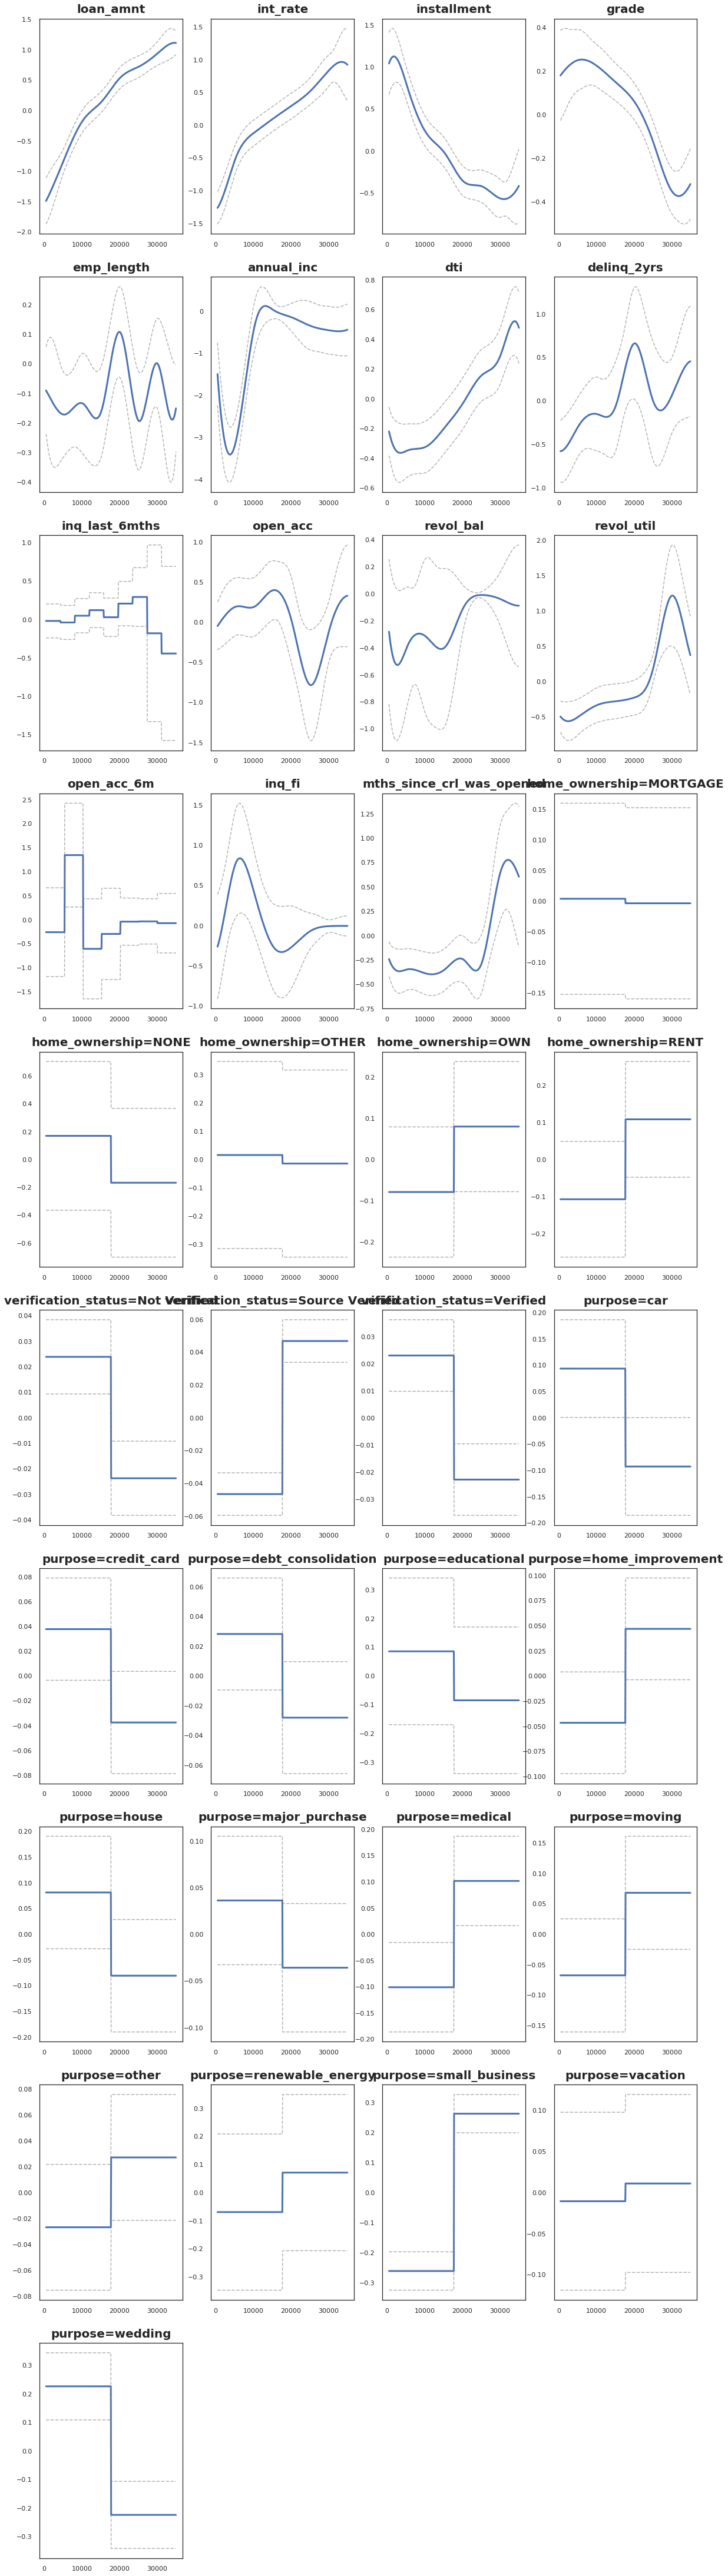

In [16]:
gamp.global_explanation_plot(gam_logistic, ln_X_train.columns)

> GAM global plots output the fitted behaviour for each variable and enable interpretation to a business expert. For instance, from the above plots we can read:
* the amount of the loan applied for by the borrower, the interest rate on the loan and the ratio calculated using the borrower’s total monthly debt payments on the total debt obligations (dti) increase the likelihood of payment default. 

#### Local explanation <a name=clfl>

In [17]:
loan_sample = ln_X_test.iloc[42]

## recovers the original format just for reading convenience
loans.data.iloc[[loan_sample.name],:]

,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,open_acc_6m,inq_fi,mths_since_crl_was_opened,bad_loan_status
80149,8000.0,14.64,275.92,5.0,6.0,MORTGAGE,96000.0,Verified,home_improvement,16.89,0.0,4.0,11.0,10899.0,31.6,1.0,1.0,244.966016,0


Probability of "default" is: 0.19


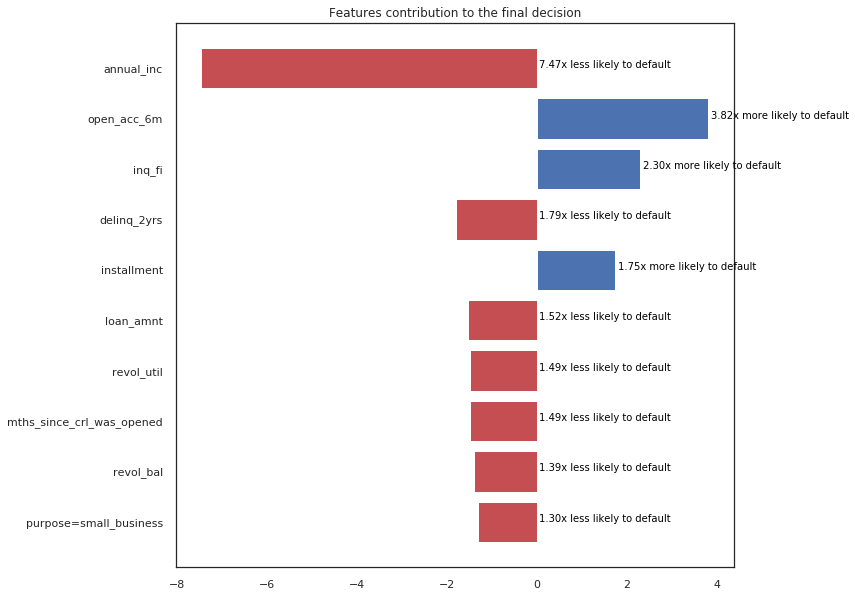

In [18]:
gamp.local_logistic_plot(loan_sample, 
                         feature_names=ln_X_test.columns, 
                         gam_logistic=gam_logistic,
                         classes_label=["not default", "default"]);

### Conclusions <a name=cls>

Generalized Additive Models are generally more accurate than Generalized Linear Models and its structure provides straight forward explanations.
The additive aspect of the model gives us a way to see the contribution at both, global and local level. 

#### Advantages:
* Interpretability advantages of Linear Models 
* Relationships between independent and dependent variable are not assumed to be linear 
* Predictor functions are automatically derived during model estimation
* Regularization of predictor functions helps avoid overfitting.
* GAMs are competitive with popular learning techniques like SVM and Random Forest.


#### Disadvantages:
* Can be computationally expensive for large data sets
* One may be tempted to make the model overly complex (with many degrees of freedom) to get more accuracy (less interpretability and possible over fitting)
* Interpretation is not so straightforward as liner models  (more involving) 


Further readings: [Intelligible Models for Health Care: Predicting Pneumonia Risk and Hospital 30-day Readmission](http://people.dbmi.columbia.edu/noemie/papers/15kdd.pdf)
